In [ ]:
from google.colab import files
uploaded = files.upload()  # Select your mental_health_data.csv


Saving Student Mental health.csv to Student Mental health.csv


Original data shape: (101, 11)

First 5 rows:
        Timestamp Choose your gender   Age What is your course?  \
0  8/7/2020 12:02             Female  18.0          Engineering   
1  8/7/2020 12:04               Male  21.0    Islamic education   
2  8/7/2020 12:05               Male  19.0                  BIT   
3  8/7/2020 12:06             Female  22.0                 Laws   
4  8/7/2020 12:13               Male  23.0         Mathemathics   

  Your current year of Study What is your CGPA? Marital status  \
0                     year 1        3.00 - 3.49             No   
1                     year 2        3.00 - 3.49             No   
2                     Year 1        3.00 - 3.49             No   
3                     year 3        3.00 - 3.49            Yes   
4                     year 4        3.00 - 3.49             No   

  Do you have Depression? Do you have Anxiety? Do you have Panic attack?  \
0                     Yes                   No                       Yes   
1 

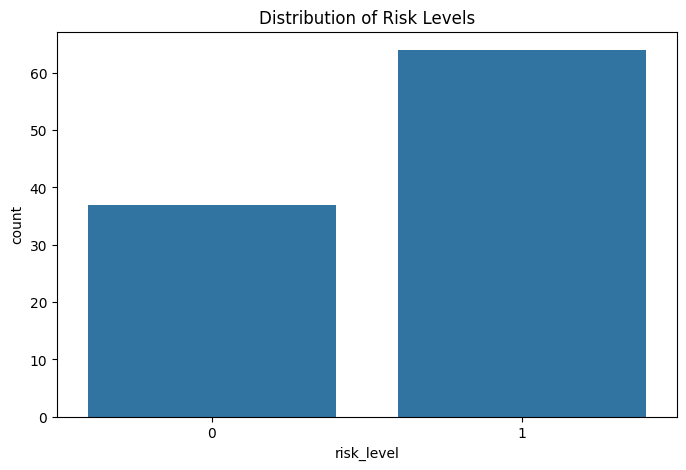

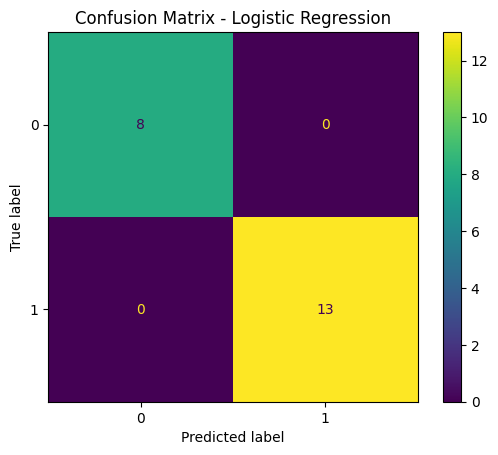

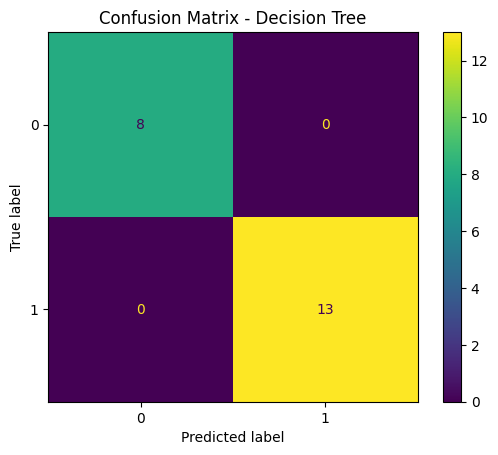

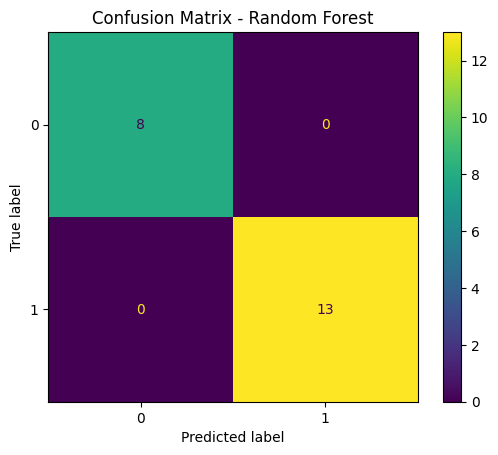


Model Performance Comparison:
                 Model  Accuracy  Precision
0  Logistic Regression       1.0        1.0
1        Decision Tree       1.0        1.0
2        Random Forest       1.0        1.0
✅ Best model saved as model.pkl


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump

# Load data
df = pd.read_csv('Student Mental health.csv')
print("Original data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# Create 'risk_level' feature
conditions = [
    (df['Do you have Depression?'].eq('Yes') |
     df['Do you have Anxiety?'].eq('Yes') |
     df['Do you have Panic attack?'].eq('Yes')),

    (df['Do you have Depression?'].eq('Yes') &
     df['Do you have Anxiety?'].eq('Yes')),

    (df['Do you have Depression?'].eq('Yes') &
     df['Do you have Anxiety?'].eq('Yes') &
     df['Do you have Panic attack?'].eq('Yes'))
]
choices = ['Medium', 'High', 'Critical']
df['risk_level'] = np.select(conditions, choices, default='Low')

# Convert 'What is your CGPA?' to numerical CGPA
cgpa_mapping = {
    '3.00 - 3.49': 3.25,
    '3.50 - 4.00': 3.75,
    '2.50 - 2.99': 2.75,
    '2.00 - 2.49': 2.25,
    '0 - 1.99': 1.0
}
df['CGPA'] = df['What is your CGPA?'].map(cgpa_mapping)

# Drop unnecessary columns
df = df.drop(['Timestamp', 'Did you seek any specialist for a treatment?', 'What is your CGPA?'], axis=1)

# Extract numerical year of study
df['Your current year of Study'] = df['Your current year of Study'].str.extract('(\d+)').astype(float)

# Encode categorical columns
le = LabelEncoder()
categorical_cols = ['Choose your gender', 'What is your course?',
                    'Marital status', 'Do you have Depression?',
                    'Do you have Anxiety?', 'Do you have Panic attack?', 'risk_level']
for col in categorical_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# Separate features and target
X = df.drop('risk_level', axis=1)
y = df['risk_level']

# Define numeric and categorical features
numeric_features = ['Age', 'CGPA', 'Your current year of Study']
categorical_features = ['Choose your gender', 'What is your course?',
                        'Marital status', 'Do you have Depression?',
                        'Do you have Anxiety?', 'Do you have Panic attack?']

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Data visualization
plt.figure(figsize=(8,5))
ax = sns.countplot(x=y)
plt.title('Distribution of Risk Levels')
plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision
    })

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=np.unique(y))
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Model Performance
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Save best model (Random Forest)
best_model = RandomForestClassifier()
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])
final_pipeline.fit(X_train, y_train)
dump(final_pipeline, 'model.pkl')
print("✅ Best model saved as model.pkl")
